# 1. Discount Rates


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset, MonthEnd
from scipy.optimize import minimize
import statsmodels.api as sm


In [12]:
FILE = "treasury_quotes_2025-11-28.xlsx"   
SHEET = "selected quotes"
FACE = 100.0
USE_PERFECT_6M_GRID = True   


In [13]:
def add_months(d, months, eom=True):
    d = pd.Timestamp(d).normalize()
    new = d + DateOffset(months=months)
    return (new + MonthEnd(0)).normalize() if eom else new.normalize()

def spot_rate_sa_from_df(T, z):
    T = np.asarray(T, float)
    z = np.asarray(z, float)
    r = np.full_like(T, np.nan, dtype=float)
    mask = T > 0
    r[mask] = 2.0 * ((1.0 / z[mask]) ** (1.0 / (2.0 * T[mask])) - 1.0)
    return r

def spot_rate_cc_from_df(T, z):
    T = np.asarray(T, float)
    z = np.asarray(z, float)
    r = np.full_like(T, np.nan, dtype=float)
    mask = T > 0
    r[mask] = -np.log(z[mask]) / T[mask]
    return r

def ns_zero_rate_cc(T, beta0, beta1, beta2, tau):
    T = np.asarray(T, dtype=float)
    x = T / tau
    a = np.where(x == 0, 1.0, (1.0 - np.exp(-x)) / x)
    b = a - np.exp(-x)
    return beta0 + beta1 * a + beta2 * b

def df_from_cc_zero(T, y_cc):
    return np.exp(-y_cc * np.asarray(T, float))



In [14]:
df = pd.read_excel(FILE, sheet_name=SHEET)

required_cols = ["quote date", "issue date", "maturity date", "ttm", "cpn rate", "dirty price"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in '{SHEET}': {missing}")

quote_date = pd.Timestamp(df["quote date"].iloc[0]).normalize()

df = df.sort_values("ttm").reset_index(drop=True)
n = len(df)



In [15]:

if not USE_PERFECT_6M_GRID:
    raise NotImplementedError("This script is set up for the perfect 6-month grid option.")

grid_start = pd.Timestamp(df["maturity date"].min()).normalize()
dates = [grid_start]
for _ in range(1, n):
    dates.append(add_months(dates[-1], 6, eom=True))


T = np.array([(pd.Timestamp(d).normalize() - quote_date).days for d in dates], dtype=float) / 365.25


C = np.zeros((n, n))
for j, r in df.iterrows():
    coupon = float(r["cpn rate"]) / 2.0
    for i in range(j + 1):
        C[j, i] = coupon + (FACE if i == j else 0.0)



In [16]:

p = df["dirty price"].astype(float).to_numpy()

if C.shape[0] == C.shape[1]:
    z_ols = np.linalg.solve(C, p)
else:
    z_ols, *_ = np.linalg.lstsq(C, p, rcond=None)



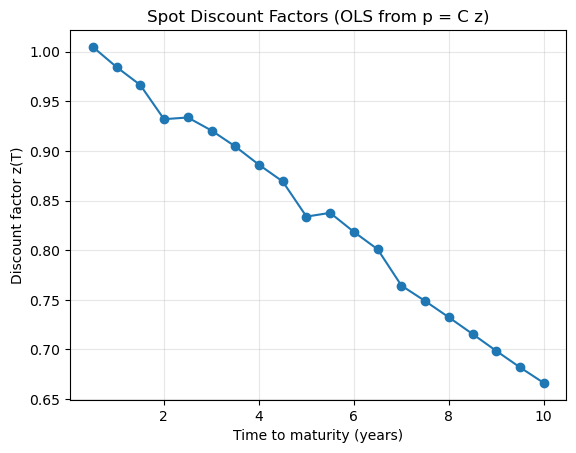

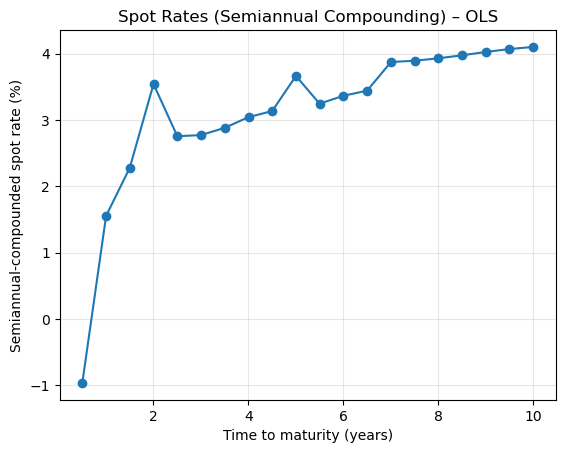

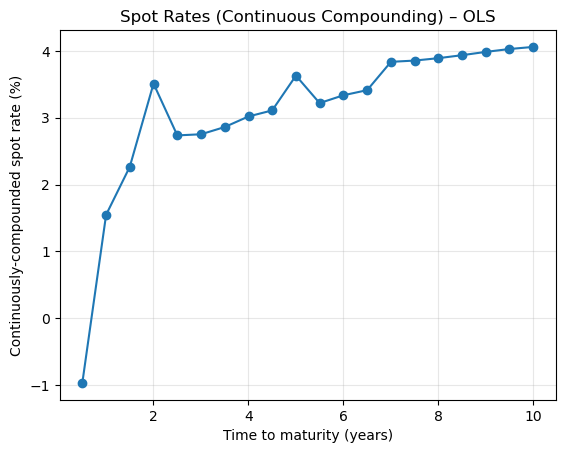

In [17]:

r_sa_ols = spot_rate_sa_from_df(T, z_ols)
r_cc_ols = spot_rate_cc_from_df(T, z_ols)

plt.figure()
plt.plot(T, z_ols, marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Discount factor z(T)")
plt.title("Spot Discount Factors (OLS from p = C z)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(T, r_sa_ols * 100.0, marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannual-compounded spot rate (%)")
plt.title("Spot Rates (Semiannual Compounding) – OLS")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(T, r_cc_ols * 100.0, marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Continuously-compounded spot rate (%)")
plt.title("Spot Rates (Continuous Compounding) – OLS")
plt.grid(True, alpha=0.3)
plt.show()




Nelson–Siegel parameter estimates (fit by SSE in prices):
  beta0 = 0.057244570
  beta1 = -0.039657695
  beta2 = -0.000092303
  tau   = 4.624147081
  SSE(price) = 12.056003 | success = True | msg = CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH


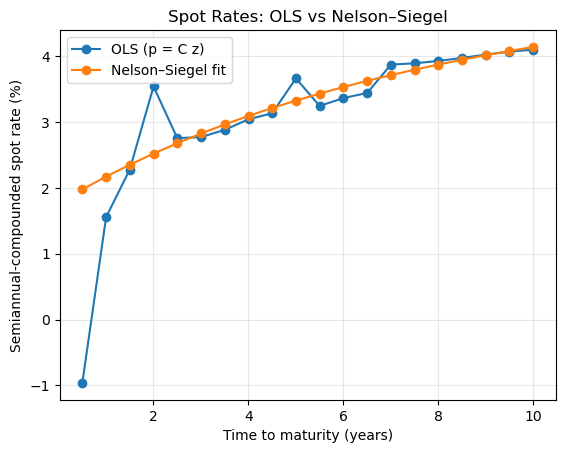

In [18]:

def sse_prices(x):
    beta0, beta1, beta2, log_tau = x
    tau = np.exp(log_tau) 
    y_cc = ns_zero_rate_cc(T, beta0, beta1, beta2, tau)
    z_ns = df_from_cc_zero(T, y_cc)
    p_model = C @ z_ns
    err = p_model - p
    return float(np.sum(err * err))

beta0_0 = float(np.nanmedian(r_cc_ols[-5:]))
x0 = np.array([beta0_0, -0.02, 0.02, np.log(2.0)], dtype=float)

bounds = [
    (-0.10, 0.20),                 # beta0
    (-0.50, 0.50),                 # beta1
    (-0.50, 0.50),                 # beta2
    (np.log(0.05), np.log(50.0)),  # log_tau  -> tau in (0.05, 50)
]

res = minimize(sse_prices, x0, method="L-BFGS-B", bounds=bounds)

beta0_hat, beta1_hat, beta2_hat, log_tau_hat = res.x
tau_hat = float(np.exp(log_tau_hat))

y_cc_hat = ns_zero_rate_cc(T, beta0_hat, beta1_hat, beta2_hat, tau_hat)
z_ns = df_from_cc_zero(T, y_cc_hat)
r_sa_ns = spot_rate_sa_from_df(T, z_ns)

print("\nNelson–Siegel parameter estimates (fit by SSE in prices):")
print(f"  beta0 = {beta0_hat:.9f}")
print(f"  beta1 = {beta1_hat:.9f}")
print(f"  beta2 = {beta2_hat:.9f}")
print(f"  tau   = {tau_hat:.9f}")
print(f"  SSE(price) = {res.fun:.6f} | success = {res.success} | msg = {res.message}")

plt.figure()
plt.plot(T, r_sa_ols * 100.0, marker="o", label="OLS (p = C z)")
plt.plot(T, r_sa_ns  * 100.0, marker="o", label="Nelson–Siegel fit")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannual-compounded spot rate (%)")
plt.title("Spot Rates: OLS vs Nelson–Siegel")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()





In [19]:

out = pd.DataFrame({
    "date": pd.to_datetime(dates).date,
    "ttm_years": T,
    "z_ols": z_ols,
    "r_sa_ols": r_sa_ols,
    "r_cc_ols": r_cc_ols,
    "z_ns": z_ns,
    "r_sa_ns": r_sa_ns,
})
print("\nCurve points (head):")
print(out.head(10).to_string(index=False))


Curve points (head):
      date  ttm_years    z_ols  r_sa_ols  r_cc_ols     z_ns  r_sa_ns
2026-05-31   0.503765 1.004878 -0.009636 -0.009659 0.990142 0.019763
2026-11-30   1.004791 0.984562  0.015544  0.015484 0.978539 0.021708
2027-05-31   1.503080 0.966520  0.022784  0.022655 0.965476 0.023512
2027-11-30   2.004107 0.932065  0.035414  0.035104 0.951041 0.025205
2028-05-31   2.505133 0.933755  0.027548  0.027360 0.935516 0.026786
2028-11-30   3.006160 0.920573  0.027720  0.027530 0.919092 0.028263
2029-05-31   3.504449 0.904592  0.028818  0.028612 0.902038 0.029637
2029-11-30   4.005476 0.886086  0.030423  0.030194 0.884319 0.030929
2030-05-31   4.503765 0.869313  0.031340  0.031097 0.866263 0.032132
2030-11-30   5.004791 0.833874  0.036631  0.036300 0.847792 0.033266


# 2. Estimating the Discount Curve with Non-Evenly Spaced Data

In [ ]:
import os
FILE_PATH = "treasury_quotes_2025-11-28.xlsx"
SHEET = "quotes"

df_raw = pd.read_excel(FILE_PATH, sheet_name=SHEET)

for c in ["quote date", "issue date", "maturity date"]:
    df_raw[c] = pd.to_datetime(df_raw[c])

ASOF = pd.to_datetime(df_raw["quote date"].mode().iloc[0]).normalize()


df = df_raw.copy()
df = df[df["ytm"].notna() & (df["ytm"] >= 0)].copy()


df = df[df["maturity date"] > ASOF].copy()


df["coupon_dec"] = df["cpn rate"].astype(float) / 100.0


PRICE_COL = "dirty price"
df["px"] = pd.to_numeric(df[PRICE_COL], errors="coerce")
df = df[df["px"].notna()].copy()

df = df.set_index("KYTREASNO", drop=False)

print("As-of date used:", ASOF.date())
print("Issues after filtering:", df.shape[0])
print("Type counts:", df["type"].value_counts().to_dict())



As-of date used: 2025-11-28
Issues after filtering: 402
Type counts: {'note': 242, 'bond': 108, 'bill': 52}


In [ ]:

FACE = 100.0

def semiannual_schedule_backwards(maturity: pd.Timestamp, asof: pd.Timestamp):

    dates = []
    d = pd.to_datetime(maturity).normalize()
    asof = pd.to_datetime(asof).normalize()
    while d > asof:
        dates.append(d)
        d = d - DateOffset(months=6)
    return sorted(set(dates))


all_dates = set()
schedules = {}

for idx, r in df.iterrows():
    sched = semiannual_schedule_backwards(r["maturity date"], ASOF)
    schedules[idx] = sched
    all_dates.update(sched)

all_dates = pd.to_datetime(sorted(all_dates))
C = pd.DataFrame(0.0, index=df.index, columns=all_dates)


for idx, r in df.iterrows():
    maturity = pd.to_datetime(r["maturity date"]).normalize()
    coupon = float(r["coupon_dec"])
    sched = schedules[idx]

    if abs(coupon) < 1e-12:
        
        C.loc[idx, maturity] += FACE
    else:
        cpn_pay = FACE * coupon / 2.0
        for d in sched:
            C.loc[idx, d] += cpn_pay
        C.loc[idx, maturity] += FACE

print("\nCashflow matrix C shape:", C.shape)


def compact_view(M: pd.DataFrame, ncols=10):
    left = M.iloc[:, :ncols]
    right = M.iloc[:, -ncols:] if M.shape[1] > ncols else M.iloc[:, :0]
    return pd.concat([left, right], axis=1)

print("\nC head (compact columns):")
print(compact_view(C.head(5)).to_string())
print("\nC tail (compact columns):")
print(compact_view(C.tail(5)).to_string())


cash_by_date = C.sum(axis=0)
most_cashflow_date = cash_by_date.idxmax()
print("\nDate with most total cashflow:", most_cashflow_date.date(),
      "| Total cashflow:", float(cash_by_date.max()))

issues_by_date = (C.abs() > 1e-12).sum(axis=0)
most_issues_date = issues_by_date.idxmax()
print("Date with most issues paying:", most_issues_date.date(),
      "| # Issues paying:", int(issues_by_date.max()))




Cashflow matrix C shape: (402, 317)

C head (compact columns):
           2025-11-30  2025-12-02  2025-12-04  2025-12-09  2025-12-11  2025-12-15  2025-12-16  2025-12-18  2025-12-23  2025-12-26  2053-08-15  2053-11-15  2054-02-15  2054-05-15  2054-08-15  2054-11-15  2055-02-15  2055-05-15  2055-08-15  2055-11-15
KYTREASNO                                                                                                                                                                                                                                                
208422            0.0       100.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0
208397            0.0         0.0       100.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         


Cashflow matrix D shape: (192, 136)

D head (compact columns):
           2025-12-02  2025-12-04  2025-12-09  2025-12-11  2025-12-15  2025-12-16  2025-12-18  2025-12-23  2025-12-26  2025-12-30  2033-11-15  2034-02-15  2034-05-15  2034-08-15  2034-11-15  2035-02-15  2035-05-15  2035-08-15  2035-11-15  2036-02-15
KYTREASNO                                                                                                                                                                                                                                                
204086            0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0
204087            0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         

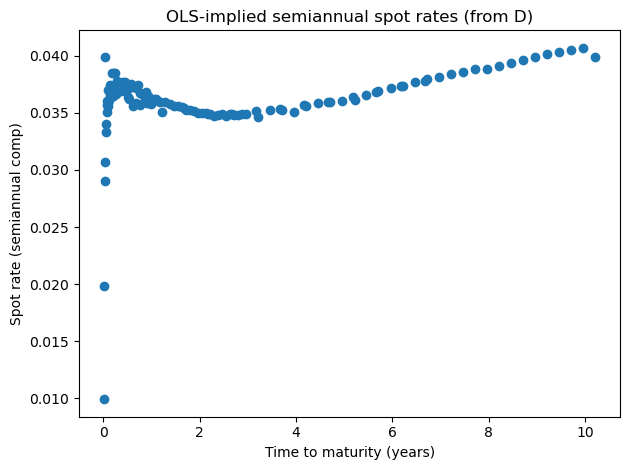

Saved: ols_spot_rates.png


In [ ]:

maturities = pd.to_datetime(df["maturity date"]).dt.normalize()

def build_D(C_all: pd.DataFrame, maturities: pd.Series, max_iter: int = 80):

    orig_cols = C_all.columns
    rows = C_all.index
    cols = orig_cols

    for _ in range(max_iter):
        matur_set = set(pd.to_datetime(maturities.loc[rows]).unique())
        cols_new = pd.to_datetime([c for c in orig_cols if c in matur_set])
        cols_new_set = set(cols_new)

        bad = []
        for r in rows:
            row_cf = C_all.loc[r, orig_cols].values
            nz_mask = np.abs(row_cf) > 1e-12
            nz_dates = set(orig_cols[nz_mask])
            if not nz_dates.issubset(cols_new_set):
                bad.append(r)

        rows_new = rows.difference(bad)

        if len(rows_new) == len(rows) and len(cols_new) == len(cols):
            return C_all.loc[rows, cols_new]

        rows, cols = rows_new, cols_new

    return C_all.loc[rows, cols]

D = build_D(C, maturities=maturities)

print("\nCashflow matrix D shape:", D.shape)


print("\nD head (compact columns):")
print(compact_view(D.head(5)).to_string())
print("\nD tail (compact columns):")
print(compact_view(D.tail(5)).to_string())


y = df.loc[D.index, "px"].values.astype(float)
X = D.values.astype(float)

df_ols, *_ = np.linalg.lstsq(X, y, rcond=None)
df_ols = pd.Series(df_ols, index=D.columns).sort_index()

def df_to_semiannual_rate(df_series: pd.Series, asof: pd.Timestamp):
    tau = (pd.to_datetime(df_series.index) - asof).days / 365.25
    tau = np.where(tau <= 0, np.nan, tau)
    r_sa = 2.0 * (np.power(df_series.values, -1.0 / (2.0 * tau)) - 1.0)
    return pd.Series(r_sa, index=df_series.index), pd.Series(tau, index=df_series.index)

r_sa_ols, tau_ols = df_to_semiannual_rate(df_ols, ASOF)

print("\nOLS discount factors summary:")
print("Min DF:", float(np.nanmin(df_ols.values)),
      "Max DF:", float(np.nanmax(df_ols.values)),
      "Any negative DF?", bool((df_ols.values < 0).any()))

OUT_DIR = ""
ols_plot_path = os.path.join(OUT_DIR, "ols_spot_rates.png")

plt.figure()
plt.scatter(tau_ols.values, r_sa_ols.values)
plt.xlabel("Time to maturity (years)")
plt.ylabel("Spot rate (semiannual comp)")
plt.title("OLS-implied semiannual spot rates (from D)")
plt.tight_layout()
plt.savefig(ols_plot_path, dpi=200)
plt.show()

print("Saved:", ols_plot_path)




Nelson–Siegel parameters (price-fit):
beta0 = 0.05388853810017948
beta1 = -0.013081262681421738
beta2 = -0.042140163642864874
lambda = 2.434809940685165
SSE    = 50.42371947826788


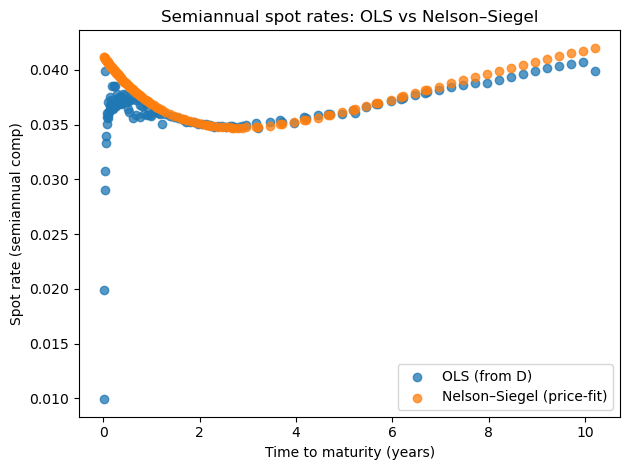

Saved: ols_vs_ns_spot_rates.png


In [27]:

cf_dates = pd.to_datetime(C.columns).sort_values()
tau_grid = np.asarray((cf_dates - ASOF).days / 365.25, dtype=float)
tau_grid = np.maximum(tau_grid, 1e-8)

C_full = np.asarray(C.values, dtype=float)
p_full = np.asarray(df.loc[C.index, "px"].values, dtype=float)

def ns_yield(tau, beta0, beta1, beta2, lam):
    tau = np.asarray(tau, dtype=float)
    x = tau / lam
    with np.errstate(divide="ignore", invalid="ignore"):
        f1 = (1 - np.exp(-x)) / x
        f1 = np.where(np.isfinite(f1), f1, 1.0)
    f2 = f1 - np.exp(-x)
    return beta0 + beta1 * f1 + beta2 * f2

def ns_discount(tau, beta0, beta1, beta2, lam):
    y = ns_yield(tau, beta0, beta1, beta2, lam)
    return np.exp(-y * tau)

def sse_ns(theta):
    beta0, beta1, beta2, lam = theta
    if lam <= 0:
        return 1e18
    dfs = ns_discount(tau_grid, beta0, beta1, beta2, lam)
    p_model = C_full @ dfs
    err = p_model - p_full
    return float(np.sum(err**2))

x0 = np.array([0.038, -0.020, 0.010, 1.5])  # start guess
bounds = [(-0.10, 0.20), (-0.50, 0.50), (-0.50, 0.50), (0.05, 10.0)]

res = minimize(sse_ns, x0, method="L-BFGS-B", bounds=bounds)
beta0, beta1, beta2, lam = res.x

print("\nNelson–Siegel parameters (price-fit):")
print("beta0 =", beta0)
print("beta1 =", beta1)
print("beta2 =", beta2)
print("lambda =", lam)
print("SSE    =", res.fun)


tau_D = np.asarray((pd.to_datetime(D.columns) - ASOF).days / 365.25, dtype=float)
tau_D = np.maximum(tau_D, 1e-8)

df_ns_D = pd.Series(ns_discount(tau_D, beta0, beta1, beta2, lam),
                    index=D.columns).sort_index()
tau_ns = pd.Series(np.asarray((pd.to_datetime(df_ns_D.index) - ASOF).days / 365.25, dtype=float),
                   index=df_ns_D.index)

r_sa_ns = 2.0 * (np.power(df_ns_D.values, -1.0/(2.0*tau_ns.values)) - 1.0)
r_sa_ns = pd.Series(r_sa_ns, index=df_ns_D.index)

ns_plot_path = os.path.join(OUT_DIR, "ols_vs_ns_spot_rates.png")

plt.figure()
plt.scatter(tau_ols.values, r_sa_ols.values, label="OLS (from D)", alpha=0.75)
plt.scatter(tau_ns.values, r_sa_ns.values, label="Nelson–Siegel (price-fit)", alpha=0.75)
plt.xlabel("Time to maturity (years)")
plt.ylabel("Spot rate (semiannual comp)")
plt.title("Semiannual spot rates: OLS vs Nelson–Siegel")
plt.legend()
plt.tight_layout()
plt.savefig(ns_plot_path, dpi=200)
plt.show()

print("Saved:", ns_plot_path)




WLS weighting: w_i = exp(-k*age_years), k = 0.75
Age (years): min 0.0 median 1.7659137577002053 max 29.78507871321013

Spot-rate differences (WLS - OLS) on common dates:
Mean abs diff: 5.8726346494747065e-05
Max  abs diff: 0.0008295713018022788


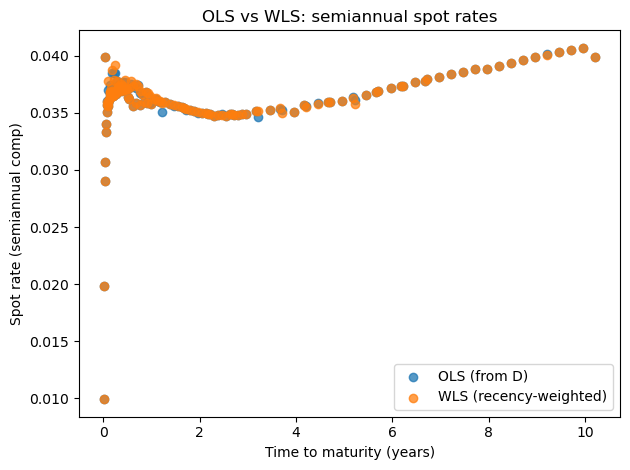

Saved: ols_vs_wls_spot_rates.png


In [29]:

age_years = (ASOF - pd.to_datetime(df.loc[D.index, "issue date"])).dt.days / 365.25
age_years = age_years.clip(lower=0)

k = 0.75
w = np.exp(-k * age_years.values) 

wls = sm.WLS(y, X, weights=w)
wls_res = wls.fit()
df_wls = pd.Series(wls_res.params, index=D.columns).sort_index()

r_sa_wls, tau_wls = df_to_semiannual_rate(df_wls, ASOF)


common = df_ols.index.intersection(df_wls.index)
diff = (r_sa_wls.loc[common].values - r_sa_ols.loc[common].values)

print("\nWLS weighting: w_i = exp(-k*age_years), k =", k)
print("Age (years): min", float(np.min(age_years)), "median", float(np.median(age_years)), "max", float(np.max(age_years)))

print("\nSpot-rate differences (WLS - OLS) on common dates:")
print("Mean abs diff:", float(np.nanmean(np.abs(diff))))
print("Max  abs diff:", float(np.nanmax(np.abs(diff))))

wls_plot_path = os.path.join(OUT_DIR, "ols_vs_wls_spot_rates.png")

plt.figure()
plt.scatter(tau_ols.values, r_sa_ols.values, label="OLS (from D)", alpha=0.75)
plt.scatter(tau_wls.values, r_sa_wls.values, label="WLS (recency-weighted)", alpha=0.75)
plt.xlabel("Time to maturity (years)")
plt.ylabel("Spot rate (semiannual comp)")
plt.title("OLS vs WLS: semiannual spot rates")
plt.legend()
plt.tight_layout()
plt.savefig(wls_plot_path, dpi=200)
plt.show()

print("Saved:", wls_plot_path)





